# Importing Data

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/knightsaddy/train.csv
/kaggle/input/reviewdf/saddy (2).csv
/kaggle/input/gdp-country/2014_world_gdp_with_codes.csv


In [3]:
df = pd.read_csv('../input/knightsaddy/train.csv')
cc = pd.read_csv("../input/gdp-country/2014_world_gdp_with_codes.csv")

# Drawing Geographical plot

In [4]:
dictr = cc.to_dict()
codedict = {}
codedict1 = {}
for i in range(1,222):
    codedict[dictr['COUNTRY'][i]] = dictr['CODE'][i]
    codedict1[dictr['CODE'][i]] = dictr['COUNTRY'][i]

In [5]:
df['country'] = df['country'].apply(lambda x: "United States" if(x=="US") else x)
df['country'] = df['country'].fillna('United States')
countryplot = pd.DataFrame((df.loc[(df['country']!='Macedonia')&((df['country']!='England')&(df['country']!='Moldova'))]['country'].apply(lambda x: codedict[x])).value_counts())
countryplot['Name'] = countryplot.index

In [6]:
data = dict(type = 'choropleth',
            locations = countryplot['Name'],
            z = countryplot['country'],
            text = countryplot['Name'].apply(lambda x: codedict1[x]),
            colorscale = 'Reds',
            autocolorscale=False,
            reversescale=False,
            marker_line_color='darkgray',
            marker_line_width=0.5,
            colorbar = {'title':'Number of sales'})
layout = dict(title = "total sales",
             geo = dict(showframe = False,
                       projection = {'type':'equirectangular'}))

In [7]:
import plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
choromap = go.Figure([data],layout)
plot(choromap)
iplot(choromap)

# Accessing Review Columns

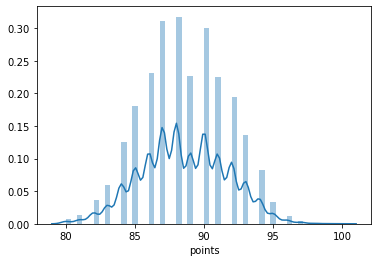

In [8]:
import seaborn as sns
sns.distplot(df['points'])

In [9]:
reviews_df = pd.DataFrame(df[['review_description','points']])

In [10]:
reviews_df

,review_description,points
0,"Classic Chardonnay aromas of apple, pear and h...",83
1,This wine is near equal parts Syrah and Merlot...,89
2,Barolo Conca opens with inky dark concentratio...,94
3,It's impressive what a small addition of Sauvi...,87
4,"This ripe, sweet wine is rich and full of drie...",88
...,...,...
82652,"Hot earth, baked cherry and mild vanilla aroma...",84
82653,"Pungent, high-pitched notes of turmeric and dr...",85
82654,This is a wine that's not just lively and frui...,87
82655,"An impressive wine, it already shows signs of ...",91


# Cleaning Reviews

1. **lowering text**
2. **Tokenisation and punctuation removal**
3. **removing words that contain numbers**
4. **Removing stop words**
5. **Remove empty tokens**
6. **Lemmatizing text**
7. **Removing words with only one letter.**

In [11]:
%%time
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
reviews_df["review_clean"] = reviews_df["review_description"].apply(lambda x: clean_text(x))

CPU times: user 4min 45s, sys: 3.92 s, total: 4min 49s
Wall time: 4min 50s


# Sentiment Analysis

In [12]:
%%time
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()
reviews_df["sentiments"] = reviews_df["review_description"].apply(lambda x: sid.polarity_scores(x))
reviews_df = pd.concat([reviews_df.drop(['sentiments'], axis=1), reviews_df['sentiments'].apply(pd.Series)], axis=1)

/opt/conda/lib/python3.7/site-packages/nltk/twitter/__init__.py:20: UserWarning:

The twython library has not been installed. Some functionality from the twitter package will not be available.



CPU times: user 1min 44s, sys: 1.81 s, total: 1min 46s
Wall time: 1min 46s


In [13]:
reviews_df.columns

Index(['review_description', 'points', 'review_clean', 'neg', 'neu', 'pos',
       'compound'],
      dtype='object')

# Calculating number of words and number of characters

In [14]:
reviews_df["nb_chars"] = reviews_df["review_description"].apply(lambda x: len(x))
reviews_df["nb_words"] = reviews_df["review_description"].apply(lambda x: len(x.split(" ")))

# Drawing wordcloud

In [15]:
# wordcloud function

from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

stopwords = set(STOPWORDS)

newStopWords = ['wine','fruit','parts','drinks','drink','not']

stopwords.update(newStopWords)


def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        stopwords = stopwords,
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()


# Word cloud of review description

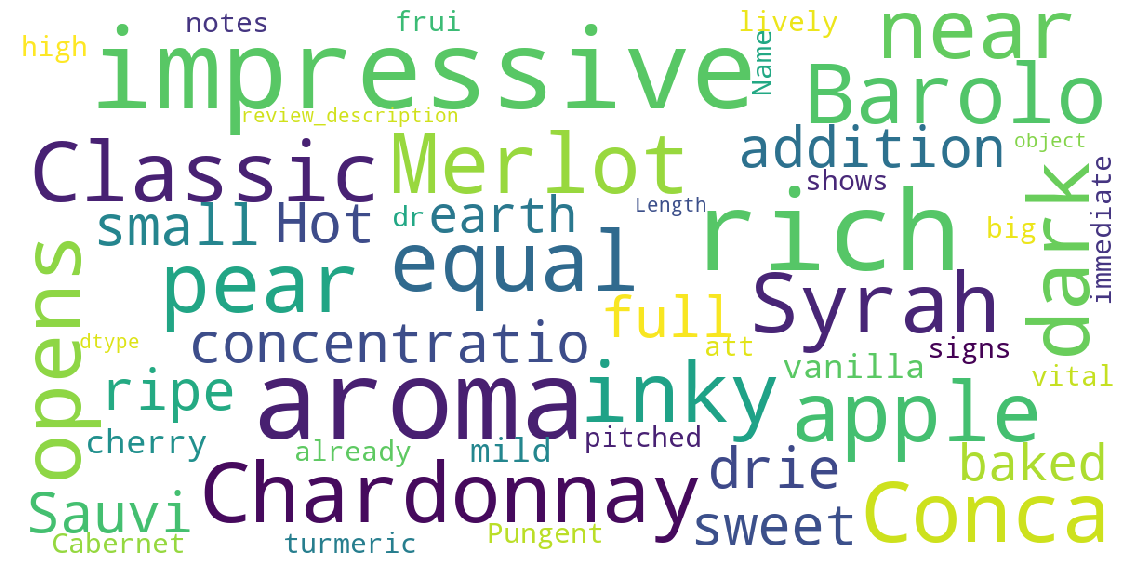

In [16]:
show_wordcloud(reviews_df["review_description"])

In [17]:
reviews_df.columns 

Index(['review_description', 'points', 'review_clean', 'neg', 'neu', 'pos',
       'compound', 'nb_chars', 'nb_words'],
      dtype='object')

In [18]:
# ['review_description','points','review_clean','neg','neg1','neu','neu1','pos','pos1','neg2','neu2','pos2','compound','nb_chars','nb_words']
# reviews_df = reviews_df.drop(['neg1','neu1','pos1','neg2','neu2','pos2'],axis=1)

In [19]:
reviews_df['price'] = df['price']

# Correlation between important columns

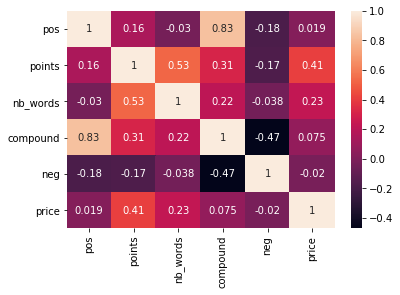

In [20]:
sns.heatmap(reviews_df[['pos','points','nb_words','compound','neg','price']].corr(),annot=True)

# Word cloud of review title

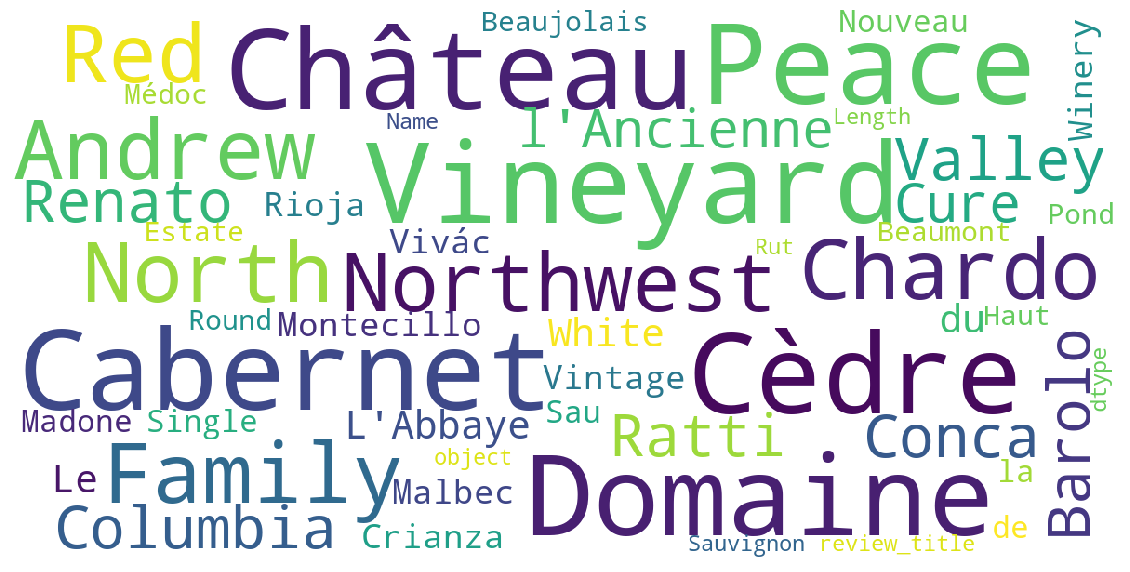

In [21]:
show_wordcloud(df["review_title"])

# Insights from reviews

> **Top 10 positive reviews**

In [22]:
reviews_df[reviews_df["nb_words"] >= 4].sort_values("compound", ascending = False)[["review_description", "pos","points","compound","neg"]].head(10)

,review_description,pos,points,compound,neg
64812,There is not just a notion of ripeness but alm...,0.391,93,0.9937,0.000
2909,Slight notes of iron oxide inform the dense an...,0.512,93,0.9911,0.000
50310,A touch of flinty reduction clings to the nose...,0.349,93,0.9910,0.000
64541,The yellow-fruited richness of mirabelle compo...,0.361,94,0.9910,0.030
20472,This is really a spectacular wine. It's hard t...,0.398,97,0.9907,0.013
78819,Luscious stone-fruit notes on the nose suggest...,0.406,92,0.9903,0.000
19479,Luscious stone-fruit notes on the nose suggest...,0.406,92,0.9903,0.000
78805,This is the most expensive Pinot Noir from Gun...,0.407,93,0.9896,0.000
52875,"Expensive, yes, but this is a very great Caber...",0.304,96,0.9890,0.034
16648,A touch of blossom honey enriches the tart but...,0.318,94,0.9887,0.000


> **Top 10 negative reviews**

In [23]:
reviews_df[reviews_df["nb_words"] >= 4].sort_values("compound", ascending = True)[["review_description", "pos","points","compound","neg"]].head(10)

,review_description,pos,points,compound,neg
70703,Disagreeable for its harsh acidity and vegetal...,0.000,82,-0.8910,0.453
39715,The leathery aromas and flavors all but oblite...,0.000,81,-0.8765,0.291
81972,"Stalky aromas suggest peach, but overall there...",0.000,82,-0.8754,0.238
45571,This Bordeaux blend feels harsh in the mouth. ...,0.027,84,-0.8709,0.261
23224,This represents the winery's attempt to recrea...,0.000,90,-0.8706,0.132
36973,"Very, very dry, but bitter in raisinskin flavo...",0.000,84,-0.8704,0.296
51102,One of a series of single-clone offerings from...,0.000,86,-0.8697,0.241
79917,"Atypical on the nose, as air freshener, berry ...",0.000,84,-0.8678,0.204
21829,The Indian Wells Cabernet Sauvignon seems a li...,0.060,86,-0.8658,0.150
43798,A bit confected and rather sweet-tasting for a...,0.000,88,-0.8625,0.211


In [24]:
reviews_df['user_name'] = df['user_name']
reviews_df['review_title'] = df['review_title']
reviews_df['designation'] = df['designation']
reviews_df['country'] = df['country']
reviews_df['region_1'] = df['region_1']
reviews_df['region_2'] = df['region_2']
reviews_df['winery'] = df['winery']
reviews_df['variety'] = df['variety']

In [25]:
reviews_df.to_csv('saddy.csv')

# Converting docs to vectors

In [ ]:
%%time
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(reviews_df["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = reviews_df["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
reviews_df = pd.concat([reviews_df, doc2vec_df], axis=1)

In [ ]:
# import pandas as pd
# reviews_df = pd.read_csv('../input/reviewdf/saddy (2).csv')

# Making sparse matrix | Applying TfIdf

In [ ]:
%%time
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(reviews_df["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = reviews_df.index
reviews_df = pd.concat([reviews_df, tfidf_df], axis=1)

# Dropping columns with number of nan value greater than 20%

In [ ]:
h = reviews_df

In [ ]:
h.drop("review_description",axis=1,inplace=True)

In [ ]:
h.drop("review_clean",axis=1,inplace=True)

In [ ]:
h.drop("region_1",axis=1,inplace=True)

In [ ]:
h.drop("region_2",axis=1,inplace=True)


In [ ]:
h.drop("user_name",axis=1,inplace=True)


In [ ]:
h.drop("designation",axis=1,inplace=True)

In [ ]:
h['price'] = h['price'].fillna(20)

In [ ]:
k = (h.isnull().sum()/h.shape[0])*100
for i in range(len(k)):
    print(h.columns[i])
    print((k[i]))

# Converting dependent column to labels

In [ ]:
j = pd.DataFrame(h['variety'].value_counts())
j['name'] = j.index
j.index = range(1,29)
j.columns = ['count','name']
d = {}
j = j.to_dict()
for i in range(1,29):
    d[j['name'][i]] = i
d

In [ ]:
reviews_df['variety'] = reviews_df['variety'].apply(lambda x: d[x])

# Specifying dependent and independent variables

In [ ]:
# feature selection
label = "variety"
ignore_cols = [label]
features = [c for c in reviews_df.columns if c not in ignore_cols]

# split the data into train and test
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(reviews_df[features], reviews_df[label], test_size = 0.20, random_state = 42)

# Applying Random forest classifier 

In [ ]:
# train a random forest classifier
rf = RandomForestClassifier(n_estimators = 100, random_state = 42)

# Fitting Random forest classifier model

In [ ]:
# rf.fit(X_train, y_train)

# Seeing feature importance

In [ ]:
# # show feature importance
# feature_importances_df = pd.DataFrame({"feature": features, "importance": rf.feature_importances_}).sort_values("importance", ascending = False)
# feature_importances_df.head(20)